In [143]:
import pandas as pd
import numpy as np
import markdown
import seaborn as sns
import plotnine
from plotnine import *
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objs as go
import plotly.plotly as py

In [153]:
url_trans = 'https://raw.githubusercontent.com/seedboxtech/datasciencetest/master/transData.csv'
url_test= 'https://raw.githubusercontent.com/seedboxtech/datasciencetest/master/testSamples.csv'

df_trans = pd.read_csv(url_trans)
df_test = pd.read_csv(url_test)

df = df_trans.merge(df_test, on ='sample_id', how='left')

In [155]:
df_pivot_count= pd.DataFrame.pivot_table(df, values='transaction_amount', index=['sample_id', 'test_group'], columns=['transaction_type'], aggfunc=np.count_nonzero)
df_pivot_count=df_pivot_count.fillna(0)

df_pivot_amount= pd.DataFrame.pivot_table(df, values='transaction_amount', index=['sample_id', 'test_group'], columns=['transaction_type'], aggfunc=np.sum)
df_pivot_amount=df_pivot_amount.fillna(0)
df_pivot_amount['Total_Amount'] = df_pivot_amount['CHARGEBACK'] + df_pivot_amount['REBILL'] + df_pivot_amount['REFUND']
#df_pivot_amount.tail(10)

## Analysis Requirements

In this analysis we would like you to answer the following questions:

1. What is the aproximate probability distribution between the test group and the control group
2. Is a user that must call-in to cancel more likely to generate at least 1 addition REBILL?
3. Is a user that must call-in to cancel more likely to generate more revenues?
4. Is a user that must call-in more likely to produce a higher chargeback rate(CHARGEBACKs/REBILLs)?

Technical Requirements:

1. Analysis must be coded in R or Python
2. Analysis must be submitted to a github repository
3. Analysis must be written in markdown format
4. Please include at least 1 vizualization with your analysis
5. Please use statistical significance tools to answer the questions we've asked
6. Include the code you used to perform the analysis in the github repository
7. Send us the link to your repository once you've completed the analysis

In [135]:
df.describe(include='all')

,transaction_id,sample_id,transaction_type,transaction_amount,test_group
count,7.430000e+03,7430.000000,7430,7430.000000,7430
unique,NaN,NaN,3,NaN,2
top,NaN,NaN,REBILL,NaN,0
freq,NaN,NaN,6961,NaN,4050
mean,5.235004e+07,30245.874024,NaN,24.935720,NaN
std,2.145001e+03,17064.733330,NaN,15.050653,NaN
min,5.234633e+07,11.000000,NaN,-39.950000,NaN
25%,5.234818e+07,15866.250000,NaN,24.950000,NaN
50%,5.235004e+07,30557.000000,NaN,24.950000,NaN
75%,5.235190e+07,44945.000000,NaN,32.950000,NaN


In [96]:
#Total Revenue by test group
Revenue_by_group = df.groupby(['test_group']).transaction_amount.sum()
#print(Revenue_by_group)

#Total number of transactions by test group
Number_transactions = df.groupby(['test_group']).transaction_id.count()
#print(Number_transactions)

#Number of call by test group
Call_number_by_group = df.groupby(['test_group']).sample_id.nunique()
#print(Call_number_by_group)

#Average transaction amount by test group
Avg_trans_amount_by_test_group = df.groupby(['test_group']).transaction_amount.mean()
#print(Avg_trans_amount_by_test_group)

## 1. What is the approximate probability distribution between the test group and the control group

Here is below the approximate probability distribution between the test group (1) and the control group (0).

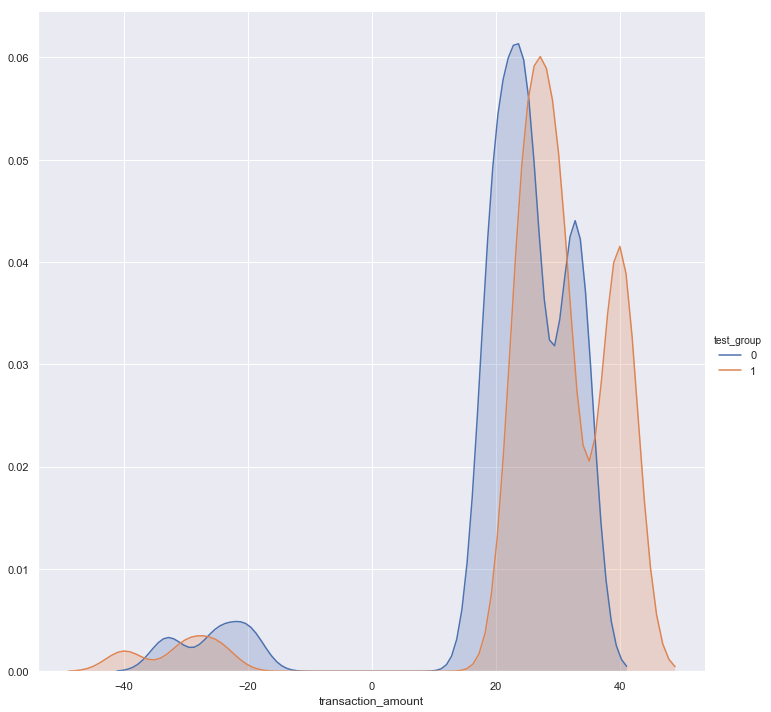

In [159]:

(sns
  .FacetGrid(df,
             height = 10,
             hue = "test_group")
  .map(sns.kdeplot, 'transaction_amount', shade=True)
 .add_legend()
)

## 2. Is a user that must call-in to cancel more likely to generate at least 1 addition REBILL?

#### Test_group column: 0= control group, 1=test group
* Control group can cancel using a web form
* Test group can only cancel by calling in

In [156]:
Call_number_by_group_no_rebill = df_pivot_count[df_pivot_count.REBILL < 0.1].groupby(['test_group']).count()["REBILL"]
print(Call_number_by_group_no_rebill)

Call_number_by_group_1_rebill = df_pivot_count[df_pivot_count.REBILL > 0.1].groupby(['test_group']).count()["REBILL"]
print(Call_number_by_group_1_rebill)

test_group
0    138
1     79
Name: REBILL, dtype: int64
test_group
0     941
1    1556
Name: REBILL, dtype: int64


Text(0.5,1,'REBILL > 1 by Test group')

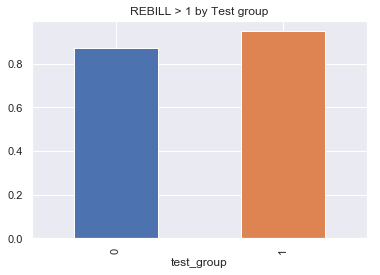

In [157]:
round(Call_number_by_group_1_rebill / (Call_number_by_group_1_rebill + Call_number_by_group_no_rebill),2).plot(kind='bar', stacked=False).set_title('REBILL > 1 by Test group')

Yes, a user that call-in to cancel is more likely to generate at least 1 addition REBILL. If we look at the percentage above, 95% of call-in users generate 1 REBILL or more against 87% for Web form users.

## 3. Is a user that must call-in to cancel more likely to generate more revenues?

No, if we look a the numbers below, we can see that a user that must call-in to cancel is generating 58.37 in average by call versus 83.26 for a user who can go through a website form.

In [158]:
#Average Revenue by call by test group
Revenue_Call_by_group = round(Revenue_by_group/Call_number_by_group,2)
print(Revenue_Call_by_group)

test_group
0    83.26
1    58.37
dtype: float64


## 4. Is a user that must call-in more likely to produce a higher chargeback rate(CHARGEBACKs/REBILLs)?

First chargeback rate can have two interpretations:
1. by number of transation
2. by total amount

### 1. by number of transation 

In [42]:
#Total number of transactions by test group
Number_transactions_bygroup_bytranstype = df.groupby(['test_group', 'transaction_type']).transaction_id.count()
print(Number_transactions_bygroup_bytranstype)

test_group  transaction_type
0           CHARGEBACK           106
            REBILL              3756
            REFUND               188
1           CHARGEBACK            57
            REBILL              3205
            REFUND               118
Name: transaction_id, dtype: int64


In [39]:
print('Webform group Chargeback Rate is equal to', round(Number_transactions_bygroup_bytranstype[0][0]/Number_transactions_bygroup_bytranstype[0][1],3))
print('Call-in group Chargeback Rate is equal to', round(Number_transactions_bygroup_bytranstype[1][0]/Number_transactions_bygroup_bytranstype[1][1],3))

Webform group Chargeback Rate is equal to 0.028
Call-in group Chargeback Rate is equal to 0.018


So, Webform group Chargeback Rate is higher than Call-in group Chargeback Rate in term of transaction, let's see what's the result by amount.

## 2. by amount

In [29]:
#Total amount by test group
Amount_bygroup_bytranstype = df.groupby(['test_group', 'transaction_type']).transaction_amount.sum()
print(Amount_bygroup_bytranstype)

test_group  transaction_type
0           CHARGEBACK           -2678.70
            REBILL               97359.20
            REFUND               -4841.60
1           CHARGEBACK           -1902.15
            REBILL              100869.75
            REFUND               -3534.10
Name: transaction_amount, dtype: float64


In [38]:
print('Webform group Chargeback Rate is equal to', round(abs(Amount_bygroup_bytranstype[0][0]/Amount_bygroup_bytranstype[0][1]), 3))
print('Call-in group Chargeback Rate is equal to', round(abs(Amount_bygroup_bytranstype[1][0]/Amount_bygroup_bytranstype[1][1]), 3))

Webform group Chargeback Rate is equal to 0.028
Call-in group Chargeback Rate is equal to 0.019


So, whatever the type of calculation, the Webform group Chargeback Rate is higher than Call-in group Chargeback Rate.